In [1]:
import dash
import dash_cytoscape as cyto
import dash_html_components as html
import dash_core_components as dcc
import pandas as pd
import json
import datetime
import plotly.express as px
import plotly.graph_objects as go
import urllib, base64

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import io

### Opening and generally preprocessing the data

In [2]:
# Email header data
emails = pd.read_csv('email headers.csv', encoding='cp1252')
# Split up single lines into multiple lines
emails = emails.assign(To=emails.To.str.split(', '))
emails = emails.explode('To')
# Extract datetimes, create new columns for date and time
emails['DateTime'] = pd.to_datetime(emails['Date'], format='%m/%d/%Y %H:%M')
emails['Time'] = pd.to_datetime(emails['Date']).dt.time
emails['Date'] = pd.to_datetime(emails['Date']).dt.date
emails

,From,To,Date,Subject,DateTime,Time
0,Sven.Flecha@gastech.com.kronos,Isak.Baza@gastech.com.kronos,2014-01-06,GT-SeismicProcessorPro Bug Report,2014-01-06 08:39:00,08:39:00
0,Sven.Flecha@gastech.com.kronos,Lucas.Alcazar@gastech.com.kronos,2014-01-06,GT-SeismicProcessorPro Bug Report,2014-01-06 08:39:00,08:39:00
1,Kanon.Herrero@gastech.com.kronos,Felix.Resumir@gastech.com.kronos,2014-01-06,Inspection request for site,2014-01-06 08:58:00,08:58:00
1,Kanon.Herrero@gastech.com.kronos,Hideki.Cocinaro@gastech.com.kronos,2014-01-06,Inspection request for site,2014-01-06 08:58:00,08:58:00
1,Kanon.Herrero@gastech.com.kronos,Inga.Ferro@gastech.com.kronos,2014-01-06,Inspection request for site,2014-01-06 08:58:00,08:58:00
...,...,...,...,...,...,...
1169,Albina.Hafon@gastech.com.kronos,Valeria.Morlun@gastech.com.kronos,2014-01-17,RE: Traffic advisory for today,2014-01-17 20:46:00,20:46:00
1169,Albina.Hafon@gastech.com.kronos,Cecilia.Morluniau@gastech.com.kronos,2014-01-17,RE: Traffic advisory for today,2014-01-17 20:46:00,20:46:00
1169,Albina.Hafon@gastech.com.kronos,Henk.Mies@gastech.com.kronos,2014-01-17,RE: Traffic advisory for today,2014-01-17 20:46:00,20:46:00
1169,Albina.Hafon@gastech.com.kronos,Dylan.Scozzese@gastech.com.kronos,2014-01-17,RE: Traffic advisory for today,2014-01-17 20:46:00,20:46:00


In [3]:
# Read the employee records, check for employment types
file_name = 'EmployeeRecords.xlsx'
sheet = 'Employee Records'
records = pd.read_excel(io=file_name, sheet_name=sheet)

# Some processing of the dataframe for displaying the data later on
records = records.fillna('None')
double_email = records[records['LastName'] == 'Sanjorge Jr.']
records = records.append(double_email, ignore_index=True)
records.at[54, 'EmailAddress'] = 'Sten.Sanjorge Jr.@gastech.com.tethys'

records.tail()

C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/3281554550.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  records = records.append(double_email, ignore_index=True)


,LastName,FirstName,BirthDate,BirthCountry,Gender,CitizenshipCountry,CitizenshipBasis,CitizenshipStartDate,PassportCountry,PassportIssueDate,PassportExpirationDate,CurrentEmploymentType,CurrentEmploymentTitle,CurrentEmploymentStartDate,EmailAddress,MilitaryServiceBranch,MilitaryDischargeType,MilitaryDischargeDate
50,Resumir,Felix,1959-06-30,Tethys,Male,Tethys,BirthNation,1959-06-30,Tethys,2005-03-20 00:00:00,2015-03-19 00:00:00,Security,Security Group Manager,2003-09-15,Felix.Resumir@gastech.com.kronos,TethanDefenseForceArmy,HonorableDischarge,1997-10-01 00:00:00
51,Bodrogi,Loreto,1989-04-17,Kronos,Male,Kronos,BirthNation,1989-04-17,None,None,None,Security,Site Control,2013-08-17,Loreto.Bodrogi@gastech.com.kronos,ArmedForcesOfKronos,HonorableDischarge,2008-10-01 00:00:00
52,Cocinaro,Hideki,1980-12-25,Tethys,Male,Tethys,BirthNation,1980-12-25,Tethys,2013-05-25 00:00:00,2023-05-24 00:00:00,Security,Site Control,2010-01-01,Hideki.Cocinaro@gastech.com.kronos,TethanDefenseForceArmy,HonorableDischarge,2009-10-01 00:00:00
53,Ferro,Inga,1989-06-17,Kronos,Female,Kronos,BirthNation,1989-06-17,None,None,None,Security,Site Control,2013-01-11,Inga.Ferro@gastech.com.kronos,ArmedForcesOfKronos,GeneralDischarge,2012-10-01 00:00:00
54,Sanjorge Jr.,Sten,1948-08-29,Tethys,Male,Tethys,BirthNation,1948-08-29,Tethys,2013-04-21 00:00:00,2023-04-20 00:00:00,Executive,President/CEO,1990-11-09,Sten.Sanjorge Jr.@gastech.com.tethys,None,None,None


In [4]:
# Read the raw articles, store them in a dictionary
article_dictionary = dict()

for i in range(845):
    with open('articles/' + str(i) + '.txt') as f:
        lines = f.readlines()
    article = ''
    for line in lines:
        article += line.strip('\n')
    article_dictionary[i] = article

In [5]:
# Open the preprocessed and sorted articles
df_files_sorted = pd.read_csv('df_sentiment_sorted.csv', parse_dates=['Date'])
df_files_sorted.head()

,index,File_Name,Date,Sentiment,Publisher,Mentioned_Names,Text,Positive,Negative,Certainty,Score
0,802,728.txt,1982-10-02,[POSITIVE (0.9918)],World Source,[],World Source Centrum's central role in the T...,1,0,0.991822,0.991822
1,702,638.txt,1982-10-02,[POSITIVE (0.9851)],International Times,[],International Times Centrum's central role in ...,1,0,0.985125,0.985125
2,232,214.txt,1982-10-03,[NEGATIVE (0.905)],Everyday News,[],Everyday News Central paper of the center in ...,0,1,0.905014,-0.905014
3,655,596.txt,1982-10-03,[POSITIVE (0.6304)],News Online Today,[],News Online Today Centrum's central role in ...,1,0,0.630370,0.630370
4,877,796.txt,1982-10-03,[POSITIVE (0.9747)],The Continent,[],The Continent The central role of the center ...,1,0,0.974651,0.974651


### Functions and supporting code for the network graphs

In [6]:
def create_json(emails, records, day: int, departments=['Administration', 'Engineering', 'Executive', 'Facilities', 'Information Technology', 'Security']):
    """Given a split-out dataframe with emails (1 from, 1 to, and a date) and , a json is created that can be
    used as input for the Cytoscape network graph."""

    # Extract the from and to emails
    emails_from = emails.From.tolist()
    emails_to = emails.To.tolist()

    # Create a list with all appearing emails and remove duplicates
    nodes = emails_from + emails_to
    nodes = list(dict.fromkeys(nodes))

    nodes_df = pd.DataFrame(nodes, columns=['EmailAddress'])
    records_mod = records[['EmailAddress', 'CurrentEmploymentType']]
    # There is one line missing in the records compared to emails: Executive Sten Sanjorge Jr. has two email addresses, one ending in .tethys (not in the records) and one ending in .kronos, suspicious?
    records_mod = records_mod.append({'EmailAddress': 'Sten.Sanjorge Jr.@gastech.com.tethys', 'CurrentEmploymentType': 'Executive'}, ignore_index=True)

    merged = nodes_df.merge(records_mod, how='inner', on=['EmailAddress'])
    merged = merged.sort_values(by=['CurrentEmploymentType'])
    merged = merged[merged['CurrentEmploymentType'].isin(departments)]
    merged_list = merged.values.tolist()

    # Create the formatted text for the nodes
    nodes_list = []
    for node in merged_list:
        name = node[0].split('@')[0].split('.')
        text = "{\"data\": {\"id\": \"" + node[0] + "\", \"label\": \"" + name[0] + " " + name[1] + "\"}, \"classes\": \"" + node[1] + "\"}"
        nodes_list.append(text)

    # Create a list of from - to email pairs
    pairs = []
    for i in range(len(emails_from)):
        if (emails_from[i] in merged['EmailAddress'].values.tolist()) and (emails_to[i] in merged['EmailAddress'].values.tolist()):
            pairs.append([emails_from[i], emails_to[i]])
        else:
            pass
    # Compute weights and add them to the pairs
    weights = []
    for pair in pairs:
        weights.append(pairs.count(pair))
    count = 0
    for pair in pairs:
        pair.append(weights[count])
        count += 1
    # Remove duplicates
    unique = []
    for pair in pairs:
        if pair not in unique:
            unique.append(pair)
        else:
            pass
    # Create the correct format for the links
    links_list = []
    for link in unique:
        text = "{\"data\": {\"source\": \"" + link[0] + "\", \"target\": \"" + link[1] + "\", \"weight\": " + str(link[2]) + "}}"
        links_list.append(text)

    # Write to the json file
    file_name = './network_data_day' + str(day) + '.json'

    with open(file_name, 'w') as network_data:
        z = 0
        network_data.writelines("[")
        while z < (len(nodes_list)):
            network_data.writelines(nodes_list[z] + ",")
            z += 1
        z = 0
        while z < (len(links_list) - 1):
            network_data.writelines(links_list[z] + ",")
            z += 1
        network_data.writelines(links_list[-1])
        network_data.writelines("]")

In [7]:
# Filter out emails from the days
emails_day1 = emails[emails['Date'] == datetime.date(2014, 1, 6)]
emails_day2 = emails[emails['Date'] == datetime.date(2014, 1, 7)]
emails_day3 = emails[emails['Date'] == datetime.date(2014, 1, 8)]
emails_day4 = emails[emails['Date'] == datetime.date(2014, 1, 9)]
emails_day5 = emails[emails['Date'] == datetime.date(2014, 1, 10)]
emails_day6 = emails[emails['Date'] == datetime.date(2014, 1, 13)]
emails_day7 = emails[emails['Date'] == datetime.date(2014, 1, 14)]
emails_day8 = emails[emails['Date'] == datetime.date(2014, 1, 15)]
emails_day9 = emails[emails['Date'] == datetime.date(2014, 1, 16)]
emails_day10 = emails[emails['Date'] == datetime.date(2014, 1, 17)]

In [8]:
create_json(emails_day1, records, 1)
create_json(emails_day2, records, 2)
create_json(emails_day3, records, 3)
create_json(emails_day4, records, 4)
create_json(emails_day5, records, 5)
create_json(emails_day6, records, 6)
create_json(emails_day7, records, 7)
create_json(emails_day8, records, 8)
create_json(emails_day9, records, 9)
create_json(emails_day10, records, 10)

C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  records_mod = records_mod.append({'EmailAddress': 'Sten.Sanjorge Jr.@gastech.com.tethys', 'CurrentEmploymentType': 'Executive'}, ignore_index=True)
C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  records_mod = records_mod.append({'EmailAddress': 'Sten.Sanjorge Jr.@gastech.com.tethys', 'CurrentEmploymentType': 'Executive'}, ignore_index=True)
C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  records_mod = records_mod.append({'EmailAddress': 'Sten.Sanjorge Jr.@gastech.com.tethys',

In [9]:
with open('network_data_day1.json', 'r') as f:
    data_day1 = json.load(f)
with open('network_data_day2.json', 'r') as f:
    data_day2 = json.load(f)
with open('network_data_day3.json', 'r') as f:
    data_day3 = json.load(f)
with open('network_data_day4.json', 'r') as f:
    data_day4 = json.load(f)
with open('network_data_day5.json', 'r') as f:
    data_day5 = json.load(f)
with open('network_data_day6.json', 'r') as f:
    data_day6 = json.load(f)
with open('network_data_day7.json', 'r') as f:
    data_day7 = json.load(f)
with open('network_data_day8.json', 'r') as f:
    data_day8 = json.load(f)
with open('network_data_day9.json', 'r') as f:
    data_day9 = json.load(f)
with open('network_data_day10.json', 'r') as f:
    data_day10 = json.load(f)

# Set the colorscale to extract colors for the network graph from
colors = px.colors.qualitative.Set3
# Import the legend image and encode it
image_filename = 'network_legend.PNG'
encoded_image = base64.b64encode(open(image_filename, 'rb').read())

In [10]:
stylesheet = [
    {
        'selector': 'node',
        'style': {
            'label': 'data(label)'
        }
    },
    {
        'selector': 'edge', # Add a toggle to turn on edge directions
        'style': {
            'mid-target-arrow-color': '#C5D3E2',
            'mid-target-arrow-shape': 'triangle',
            'arrow-scale': 2
        }
    },
    {
        'selector': '[weight > 3]',
        'style': {
            'line-color': 'red'
        }
    },
    {
        'selector': '.Information',
        'style': {
            'background-color': colors[0]
        }
    }
    ,
    {
        'selector': '.Executive',
        'style': {
            'background-color': colors[1]
        }
    },
    {
        'selector': '.Engineering',
        'style': {
            'background-color': colors[2]
        }
    },
    {
        'selector': '.Security',
        'style': {
            'background-color': colors[3]
        }
    },
    {
        'selector': '.Facilities',
        'style': {
            'background-color': colors[4]
        }
    },
    {
        'selector': '.Administration',
        'style': {
            'background-color': colors[5]
        }
    }
]

### Functions and supporting code for the PCA plots

In [11]:
def make_pca(hours):

    vector_list = []
    time_vector = []
    # In de dataset beginnen de emails op 2014-1-6 en eindigen ze op 2014-1-17, hoort dit anders te zijn hier?
    start_date = datetime.datetime(2014, 1, 7, 0, 0, 0)
    end_date = datetime.datetime(2014, 1, 19, 0, 0, 0)
    delta = datetime.timedelta(hours=hours)

    while start_date <= end_date:
        adjacency_mat = np.zeros((len(names_dict), len(names_dict)))
        for j in range(len(from_new)):
            if time_new[j] < start_date and time_new[j] > (start_date - delta):
                adjacency_mat[names_dict[from_new[j]]][names_dict[to_new[j]]] += 1
        vector_list.append(adjacency_mat.flatten())
        time_vector.append(start_date)
        start_date += delta

    df = pd.DataFrame(vector_list)
    return df, time_vector

In [12]:
def create_figure(hours):
    df, time_vector = make_pca(hours)
    x = df.values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                               , columns = ['principal component 1', 'principal component 2'])
    principalDf['Date'] = time_vector
    principalDf['Time'] = range(len(time_vector))
    fig = px.scatter(principalDf, x='principal component 1', y='principal component 2', color = 'Time',
                     color_continuous_scale='Bluered_r', hover_data = ['Date'])
    return fig

In [13]:
# Create data structures necessary for running the functions/callbacks
from_new = emails['From'].tolist()
to_new = emails['To'].tolist()
time_new = emails['DateTime'].tolist()

unique_emails = emails['From'].drop_duplicates().reset_index()
names_dict = {value: key for key, value in unique_emails['From'].to_dict().items()}

### Functions and supporting code for the wordcloud plot

In [14]:
def comma_cutter(sentence):
    '''Don't forget to add a real docstring here!'''
    names = []
    if sentence.find(',') == -1:
        return [int(sentence)]
    while sentence.find(',') != -1:
        index = sentence.find(',')
        names.append(int(sentence[:index].strip(' ')))
        sentence = sentence[index + 1:]
    names.append(int(sentence.strip(" ")))
    return names

In [15]:
image_filename2 = 'wordcloud_placeholder.PNG'
encoded_image2 = base64.b64encode(open(image_filename2, 'rb').read())

### Functions and supporting code for the sentiment analysis plots

In [16]:
# Group the articles by date and compute some statistics (add to the df)
df_grouped = df_files_sorted.groupby('Date').sum()
df_grouped['Total_articles'] = df_grouped['Positive'] + df_grouped['Negative']

df_grouped['%_Positive'] = df_grouped['Positive'] / df_grouped['Total_articles'] * 100

df_grouped['%_Negative'] = 100 - df_grouped['%_Positive']
df_grouped['Avg_score'] = df_files_sorted.groupby('Date').mean()['Score']
df_grouped['Avg_score_100'] = df_grouped['Avg_score'] * 100

In [17]:
# Group the article by publisher and compute some summary statistics
df = df_files_sorted.groupby('Publisher').sum()
df['Total_articles']  = df['Positive'] + df['Negative']
df['%_Positive'] = df['Positive'] / df['Total_articles'] * 100
df['%_Negative'] = 100 - df['%_Positive']
df['Avg_score'] = df_files_sorted.groupby('Publisher').mean()['Score']
df['Avg_score_100'] = df['Avg_score'] * 100

df_publisher = df.copy()

In [18]:
def heatmap_df(feature):
    '''Make a heatmap with years as rows and months as columns.
    '''
    df = df_grouped.groupby(df_grouped.index.to_period("M")).mean()[[feature]].copy()
    df['year'] = df.index.year#.unique().to_list() # years as rows
    df['month'] = df.index.month

    rows = list(range(df.index.year.unique().to_list()[0], df.index.year.unique().to_list()[-1]+1))
    cols = df.index.month.unique().to_list()

    hm = pd.DataFrame(columns=cols, index=rows) # make empty df to fill in for the heatmap
    for index, values in df.iterrows(): # fill in heatmap
        cell = hm.loc[values.year, values['month']]
        if pd.isnull(cell):
            hm.loc[values.year, values['month']] = values[feature]
        else:
            print('something went wrong')
            hm.loc[values.year, values['month']] += values[feature]
    hm = hm[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]

    return hm

In [19]:
def fig_publisher():
    ''' Create a barchart that displays the number of articles per publisher
    '''
    fig = go.Figure(
        data=[
            go.Bar(name='Total articles', x=df_publisher.index, y=df_publisher["Total_articles"],hovertext=['Mentioned_Names']),
            go.Bar(name='Negative',       x=df_publisher.index, y=df_publisher["Negative"]      ,hovertext=['Mentioned_Names']),
            go.Bar(name='Positive',       x=df_publisher.index, y=df_publisher["Positive"]      ,hovertext=['Mentioned_Names'])]
    )
    # Change the bar mode
    fig.update_layout(title="Number of articles per publisher",
                      xaxis_title="Publisher",
                      yaxis_title="Number of articles (count)",barmode='group')
    return fig

### Set the GUI layout

In [20]:
app = dash.Dash(__name__)

In [21]:
app.layout = html.Div([
    # Network graphs layout
    html.Div([
        html.Div([
            html.Label(['Select a part of the day to filter'],
                       style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'}),
            dcc.RadioItems(
                id='my-radio',
                options=[{'label': 'Morning', 'value': 'morning'},
                         {'label': 'Afternoon', 'value': 'afternoon'},
                         {'label': 'Evening', 'value': 'evening'}]
            )
        ], style={'padding': 10, 'flex': 1}),
        html.Div([
            html.Label(['Select department(s) to display'],
                       style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'}),
            dcc.Checklist(
                id='my-checklist',
                options=[{'label': 'Administration', 'value': 'Administration'},
                         {'label': 'Engineering', 'value': 'Engineering'},
                         {'label': 'Executive', 'value': 'Executive'},
                         {'label': 'Facilities', 'value': 'Facilities'},
                         {'label': 'Information Technology', 'value': 'Information Technology'},
                         {'label': 'Security', 'value': 'Security'}],
                value=['Administration', 'Engineering', 'Executive', 'Facilities', 'Information Technology', 'Security'],
                labelStyle={'display': 'inline-block'}
            ),
            html.Img(src='data:image/png;base64,{}'.format(encoded_image.decode()),
                     style={'width': '87%'})
        ], style={'padding': 10, 'flex': 1})
    ], style={'display': 'flex', 'flex-direction': 'row'}),
    html.Div([
        html.Label(['2014-01-06'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-07'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-08'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-09'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-10'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'})
    ]),
    html.Div([
        cyto.Cytoscape(
            id='cytoscape-v1',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day1,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v2',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day2,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v3',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day3,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v4',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day4,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v5',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day5,
            stylesheet=stylesheet
        )
    ]),
    html.Div([
        html.P(id='tapNodeData-cyto-v1',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v2',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v3',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v4',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v5',
               style={'width': '20%', 'display': 'inline-block'})
    ]),
    html.Div([
        html.Label(['2014-01-13'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-14'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-15'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-16'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
        html.Label(['2014-01-17'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px',
                          'width': '20%', 'display': 'inline-block'}),
    ]),
    html.Div([
        cyto.Cytoscape(
            id='cytoscape-v6',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day6,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v7',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day7,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v8',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day8,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v9',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day9,
            stylesheet=stylesheet
        ),
        cyto.Cytoscape(
            id='cytoscape-v10',
            layout={'name': 'circle'},
            style={'width': '20%', 'height': '300px', 'display': 'inline-block'},
            elements=data_day10,
            stylesheet=stylesheet
        )
    ]),
    html.Div([
        html.P(id='tapNodeData-cyto-v6',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v7',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v8',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v9',
               style={'width': '20%', 'display': 'inline-block'}),
        html.P(id='tapNodeData-cyto-v10',
               style={'width': '20%', 'display': 'inline-block'})
    ]),
    # PCA plot layout
    html.Div([
        html.Label(['PCA representation of the email network graphs'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'}),
        dcc.Graph(
            id='pca'
        ),
        html.Label(['Amount of hours per graph'],
                   style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'}),
        dcc.Slider(
            min=1, max=24, step=1,
            value=10,
            id='slider',
            marks={
                1: '1',
                6: '6',
                12: '12',
                18: '18',
                24: '24'
            }
        )
    ]),
    # Sentiment analysis view
    html.Div([
        # Sentiment heatmap and wordcloud
        html.Div([
            html.Label(['Choose the feature to display'],
                       style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'}),
            dcc.RadioItems(
                id='medals',
                options=[{'label': 'Total_articles', 'value': 'Total_articles'},
                         {'label': 'Positive', 'value': 'Positive'},
                         {'label': 'Negative', 'value': 'Negative'},
                         {'label': '%_Positive', 'value': '%_Positive'},
                         {'label': '%_Negative', 'value': '%_Negative'},
                         {'label': 'Avg_score', 'value': 'Avg_score'}],
                value='Avg_score',
                labelStyle={'display': 'block'}
            ),
            html.Div([
                html.Label(['Wordcloud of article text'],
                           style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'})
            ]),
            html.Div([
                html.Img(
                    id='wordcloud',
                    src='data:image/png;base64,{}'.format(encoded_image2.decode()),
                )
            ]),
            html.P(['Choose which article(s) to display in the wordcloud'], style={'font-weight': 'bold'}),
            dcc.Input(
                id='article_num',
                type='text',
                placeholder='Separate article numbers by comma',
                debounce=True
            )
        ], style={'padding': 10, 'flex': 1}),
        html.Div([
            html.Label(['Number of articles and sentiment score of articles over time'],
                       style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'}),

            dcc.Graph(id="graph")
        ], style={'padding': 10, 'flex': 1})
    ], style={'display': 'flex', 'flex-direction': 'row'}),

    # Sentiment scatter plot and publisher count barcharts
    html.Label(['Explore articles in scatter plot'],
               style={'font-weight': 'bold', 'text-align': 'center', 'font-size': '22px'}),
    dcc.Graph(id="graph2"),
    html.P(['Choose feature for the x-axis'], style={'font-weight': 'bold'}),
    dcc.RadioItems(
        id='xitems',
        options=[{'label': 'File_Name', 'value': 'File_Name'},
                 {'label': 'Date', 'value': 'Date'},
                 {'label': 'Publisher', 'value': 'Publisher'},
                 {'label': 'Mentioned_Names', 'value': 'Mentioned_Names'},
                 {'label': 'Positive', 'value': 'Positive'},
                 {'label': 'Negative', 'value': 'Negative'},
                 {'label': 'Certainty', 'value': 'Certainty'},
                 {'label': 'Score', 'value': 'Score'}],
        value='Date',
    ),
    html.P(['Choose feature for the y-axis'], style={'font-weight': 'bold'}),
    dcc.RadioItems(
        id='yitems',
        options=[{'label': 'File_Name', 'value': 'File_Name'},
                 {'label': 'Date', 'value': 'Date'},
                 {'label': 'Publisher', 'value': 'Publisher'},
                 {'label': 'Mentioned_Names', 'value': 'Mentioned_Names'},
                 {'label': 'Positive', 'value': 'Positive'},
                 {'label': 'Negative', 'value': 'Negative'},
                 {'label': 'Certainty', 'value': 'Certainty'},
                 {'label': 'Score', 'value': 'Score'}],
        value='Score',
    ),
    html.P(['Choose feature for the color'], style={'font-weight': 'bold'}),
    dcc.RadioItems(
        id='colorfig2',
        options=[{'label': 'Publisher', 'value': 'Publisher'},
                 {'label': 'Mentioned_Names', 'value': 'Mentioned_Names'},
                 {'label': 'Certainty', 'value': 'Certainty'}],
        value='Mentioned_Names',
    ),
    dcc.Graph(id='graph3', figure=fig_publisher()) # Even kijken of deze plot echt relevant is om in de GUI te houden
])

### Callback functions for the network graphs

In [22]:
@app.callback(
    [dash.dependencies.Output(component_id='cytoscape-v1', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v2', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v3', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v4', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v5', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v6', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v7', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v8', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v9', component_property='elements'),
     dash.dependencies.Output(component_id='cytoscape-v10', component_property='elements')],
    [dash.dependencies.Input(component_id='my-radio', component_property='value'),
     dash.dependencies.Input(component_id='my-checklist', component_property='value')])

def update_output(radio_value, checklist_values):

    emails_day1 = emails[emails['Date'] == datetime.date(2014, 1, 6)]
    emails_day2 = emails[emails['Date'] == datetime.date(2014, 1, 7)]
    emails_day3 = emails[emails['Date'] == datetime.date(2014, 1, 8)]
    emails_day4 = emails[emails['Date'] == datetime.date(2014, 1, 9)]
    emails_day5 = emails[emails['Date'] == datetime.date(2014, 1, 10)]
    emails_day6 = emails[emails['Date'] == datetime.date(2014, 1, 13)]
    emails_day7 = emails[emails['Date'] == datetime.date(2014, 1, 14)]
    emails_day8 = emails[emails['Date'] == datetime.date(2014, 1, 15)]
    emails_day9 = emails[emails['Date'] == datetime.date(2014, 1, 16)]
    emails_day10 = emails[emails['Date'] == datetime.date(2014, 1, 17)]

    if radio_value == 'morning':
        emails_day1 = emails_day1[emails_day1['Time'] <= datetime.time(12, 0, 0)]
        emails_day2 = emails_day2[emails_day2['Time'] <= datetime.time(12, 0, 0)]
        emails_day3 = emails_day3[emails_day3['Time'] <= datetime.time(12, 0, 0)]
        emails_day4 = emails_day4[emails_day4['Time'] <= datetime.time(12, 0, 0)]
        emails_day5 = emails_day5[emails_day5['Time'] <= datetime.time(12, 0, 0)]
        emails_day6 = emails_day6[emails_day6['Time'] <= datetime.time(12, 0, 0)]
        emails_day7 = emails_day7[emails_day7['Time'] <= datetime.time(12, 0, 0)]
        emails_day8 = emails_day8[emails_day8['Time'] <= datetime.time(12, 0, 0)]
        emails_day9 = emails_day9[emails_day9['Time'] <= datetime.time(12, 0, 0)]
        emails_day10 = emails_day10[emails_day10['Time'] <= datetime.time(12, 0, 0)]

    if radio_value == 'afternoon':
        emails_day1 = emails_day1[(emails_day1['Time'] > datetime.time(12, 0, 0)) & (emails_day1['Time'] <= datetime.time(18, 0, 0))]
        emails_day2 = emails_day2[(emails_day2['Time'] > datetime.time(12, 0, 0)) & (emails_day2['Time'] <= datetime.time(18, 0, 0))]
        emails_day3 = emails_day3[(emails_day3['Time'] > datetime.time(12, 0, 0)) & (emails_day3['Time'] <= datetime.time(18, 0, 0))]
        emails_day4 = emails_day4[(emails_day4['Time'] > datetime.time(12, 0, 0)) & (emails_day4['Time'] <= datetime.time(18, 0, 0))]
        emails_day5 = emails_day5[(emails_day5['Time'] > datetime.time(12, 0, 0)) & (emails_day5['Time'] <= datetime.time(18, 0, 0))]
        emails_day6 = emails_day6[(emails_day6['Time'] > datetime.time(12, 0, 0)) & (emails_day6['Time'] <= datetime.time(18, 0, 0))]
        emails_day7 = emails_day7[(emails_day7['Time'] > datetime.time(12, 0, 0)) & (emails_day7['Time'] <= datetime.time(18, 0, 0))]
        emails_day8 = emails_day8[(emails_day8['Time'] > datetime.time(12, 0, 0)) & (emails_day8['Time'] <= datetime.time(18, 0, 0))]
        emails_day9 = emails_day9[(emails_day9['Time'] > datetime.time(12, 0, 0)) & (emails_day9['Time'] <= datetime.time(18, 0, 0))]
        emails_day10 = emails_day10[(emails_day10['Time'] > datetime.time(12, 0, 0)) & (emails_day10['Time'] <= datetime.time(18, 0, 0))]

    if radio_value == 'evening':
        emails_day1 = emails_day1[emails_day1['Time'] > datetime.time(18, 0, 0)]
        emails_day2 = emails_day2[emails_day2['Time'] > datetime.time(18, 0, 0)]
        emails_day3 = emails_day3[emails_day3['Time'] > datetime.time(18, 0, 0)]
        emails_day4 = emails_day4[emails_day4['Time'] > datetime.time(18, 0, 0)]
        emails_day5 = emails_day5[emails_day5['Time'] > datetime.time(18, 0, 0)]
        emails_day6 = emails_day6[emails_day6['Time'] > datetime.time(18, 0, 0)]
        emails_day7 = emails_day7[emails_day7['Time'] > datetime.time(18, 0, 0)]
        emails_day8 = emails_day8[emails_day8['Time'] > datetime.time(18, 0, 0)]
        emails_day9 = emails_day9[emails_day9['Time'] > datetime.time(18, 0, 0)]
        emails_day10 = emails_day10[emails_day10['Time'] > datetime.time(18, 0, 0)]

    try:
        create_json(emails_day1, records, 1, checklist_values)
        with open('network_data_day1.json', 'r') as f:
            elements_day1 = json.load(f)
    except:
        elements_day1 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day2, records, 2, checklist_values)
        with open('network_data_day2.json', 'r') as f:
            elements_day2 = json.load(f)
    except:
        elements_day2 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day3, records, 3, checklist_values)
        with open('network_data_day3.json', 'r') as f:
            elements_day3 = json.load(f)
    except:
        elements_day3 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day4, records, 4, checklist_values)
        with open('network_data_day4.json', 'r') as f:
            elements_day4 = json.load(f)
    except:
        elements_day4 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day5, records, 5, checklist_values)
        with open('network_data_day5.json', 'r') as f:
            elements_day5 = json.load(f)
    except:
        elements_day5 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day6, records, 6, checklist_values)
        with open('network_data_day6.json', 'r') as f:
            elements_day6 = json.load(f)
    except:
        elements_day6 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day7, records, 7, checklist_values)
        with open('network_data_day7.json', 'r') as f:
            elements_day7 = json.load(f)
    except:
        elements_day7 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day8, records, 8, checklist_values)
        with open('network_data_day8.json', 'r') as f:
            elements_day8 = json.load(f)
    except:
        elements_day8 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day9, records, 9, checklist_values)
        with open('network_data_day9.json', 'r') as f:
            elements_day9 = json.load(f)
    except:
        elements_day9 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]
    try:
        create_json(emails_day10, records, 10, checklist_values)
        with open('network_data_day10.json', 'r') as f:
            elements_day10 = json.load(f)
    except:
        elements_day10 = [{'data': {'id': 'one', 'label': 'Nothing to display'}}]

    return elements_day1, elements_day2, elements_day3, elements_day4, elements_day5, elements_day6, elements_day7, elements_day8, elements_day9, elements_day10

In [23]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v1', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v1', component_property='tapNodeData')]
)

def displayTap_v1(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Mail:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [24]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v2', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v2', component_property='tapNodeData')]
)

def displayTap_v2(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [25]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v3', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v3', component_property='tapNodeData')]
)

def displayTap_v3(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [26]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v4', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v4', component_property='tapNodeData')]
)

def displayTap_v4(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [27]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v5', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v5', component_property='tapNodeData')]
)

def displayTap_v5(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [28]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v6', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v6', component_property='tapNodeData')]
)

def displayTap_v6(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [29]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v7', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v7', component_property='tapNodeData')]
)

def displayTap_v7(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [30]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v8', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v8', component_property='tapNodeData')]
)

def displayTap_v8(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [31]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v9', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v9', component_property='tapNodeData')]
)

def displayTap_v9(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

In [32]:
@app.callback(
    dash.dependencies.Output(component_id='tapNodeData-cyto-v10', component_property='children'),
    [dash.dependencies.Input(component_id='cytoscape-v10', component_property='tapNodeData')]
)

def displayTap_v10(data):
    email = data['id']
    record = records[records['EmailAddress'] == email].reset_index()

    return "Name: " + data['label'] + ', Email:' + email + ', Country: ' + record['CitizenshipCountry'][0] + ', Military: ' + record['MilitaryServiceBranch'][0]

### Callback function for the PCA email network graph

In [33]:
@app.callback(
    dash.dependencies.Output(component_id='pca', component_property='figure'),
    [dash.dependencies.Input(component_id='slider', component_property='value')]
)

def create_figure(slider):

    df, time_vector = make_pca(slider)

    x = df.values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                               , columns = ['principal component 1', 'principal component 2'])
    principalDf['Date'] = time_vector
    principalDf['Time'] = range(len(time_vector))
    figure = px.scatter(principalDf, x='principal component 1', y='principal component 2', color = 'Time',
                        color_continuous_scale='Bluered_r', hover_data = ['Date'])

    return figure

### Callback function for the article wordcloud graph

In [34]:
@app.callback(
    dash.dependencies.Output(component_id='wordcloud', component_property='src'),
    [dash.dependencies.Input(component_id='article_num', component_property='value')]
)

def create_wordcloud(article_num):
    nums = comma_cutter(article_num)

    text = ''
    for article in nums:
        text += ' ' + article_dictionary[article]
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    image = io.BytesIO()
    plt.savefig(image, format='png')
    image.seek(0)  # rewind the data
    string = base64.b64encode(image.read())

    image_64 = 'data:image/png;base64,' + urllib.parse.quote(string)
    return image_64

### Callback functions for the sentiment heatmap and scatterplot

In [35]:
@app.callback(
    dash.dependencies.Output(component_id="graph", component_property="figure"),
    [dash.dependencies.Input(component_id="medals", component_property="value")])

def filter_heatmap(feature):

    hm = heatmap_df(feature)
    fig = px.imshow(hm, color_continuous_scale='Bluered_r',width=600, height=700)
    fig.update_layout(
        title="Articles over time",
        xaxis_title="Month",
        yaxis_title="Year")

    return fig

In [36]:
@app.callback(
    dash.dependencies.Output(component_id="graph2", component_property="figure"),
    [dash.dependencies.Input(component_id="xitems", component_property="value"),
     dash.dependencies.Input(component_id='yitems', component_property='value'),
     dash.dependencies.Input(component_id='colorfig2', component_property='value')])

def scatter_plot(xaxis, yaxis, colour):

    df = df_files_sorted.copy()
    df.Text = df.Text.str.wrap(60)
    df.Text = df.Text.apply(lambda x: x.replace('\n', '<br>'))

    fig = px.scatter(df, x=xaxis, y=yaxis, color=colour,
                     hover_data={'File_Name':True,
                                 'Publisher':True,
                                 'Mentioned_Names':True,
                                 'Date':True,
                                 'Score':True,
                                 'Text': True
                                 }
                     )
    return fig

### Run the application

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20182402\AppData\Local\Temp/ipykernel_6188/4014067374.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

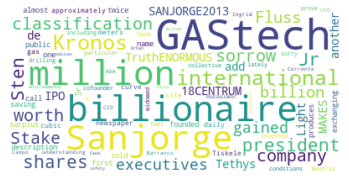

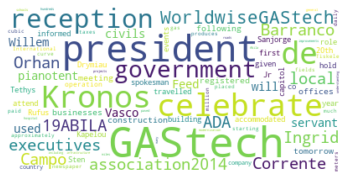

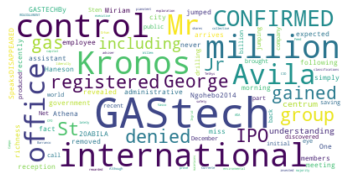

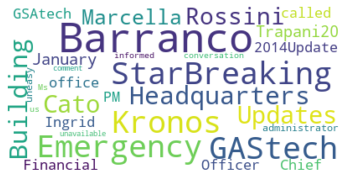

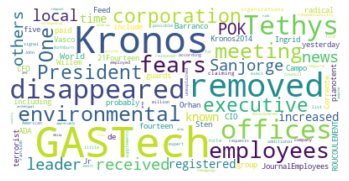

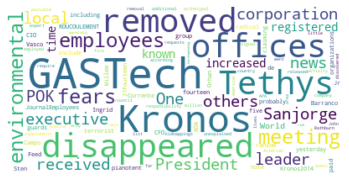

In [37]:
app.run_server(debug=True, use_reloader=False)

Next steps:
- Add other days as well.
- Add checkboxes to select departments.
- Add radioitems (or maybe checkboxes?) to select on graph bigger.
- On click, remove a node and it's edges.